In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

from pykalman import KalmanFilter
import pymc3 as pm
from pymc3.distributions.timeseries import AR1
from pymc3.distributions.timeseries import GaussianRandomWalk

%matplotlib inline

/Users/Xinhui/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

dates = data.index[1:]

In [22]:
window = 5
D = []
for t in range(len(delta_r) - window):
    y = ret[t : t+window]
    x = delta_r[t : t+window]
    model = sm.OLS(y, x)
    result = model.fit()
    D.append(- result.params[0])

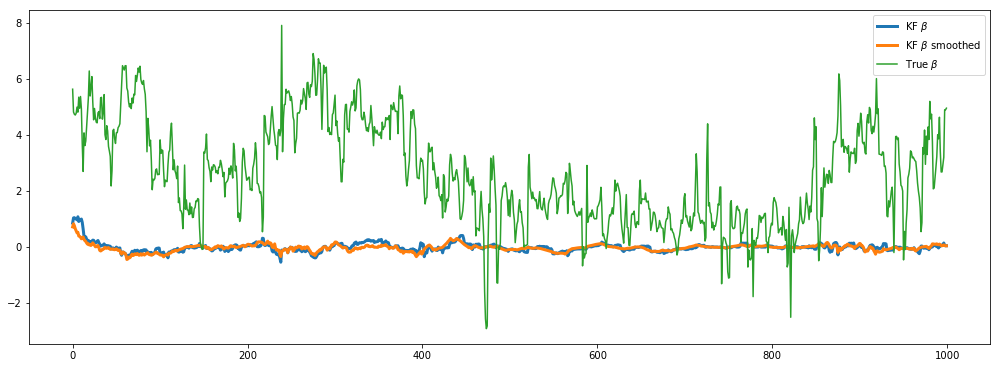

In [37]:
Total_T = 1000

dr = 1e-2
trans_cov_r = dr / (1 - dr) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[D[:Total_T]], [np.ones(Total_T)]]).T, axis=1)


kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[5,0],
                  initial_state_covariance=np.array([[1, 0], [0, 1]]),
                    
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  
                  observation_covariance=0.3,
                  transition_covariance=trans_cov_r)

theta = kf_r.em(prices[:Total_T])
state_means_r, _ = kf_r.filter(prices[:Total_T])
state_means_r_smooth, _ = kf_r.smooth(prices[:Total_T])

fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(2, 1, 1)
#_, axarr = plt.subplots(2, sharex=True)
ax.plot(state_means_r[:,0], label=r'KF $\beta$', lw=3)
ax.plot(state_means_r_smooth[:,0], label=r'KF $\beta$ smoothed', lw=3)
ax.plot(D[:Total_T], label=r'True $\beta$')
ax.legend()

fig.tight_layout()


## Regime Switching

### Return ~$\Delta R$

In [16]:
# Hamilton regime switching

y = ret[:Total_T]
x = delta_r[:Total_T]
mod_hamilton = sm.tsa.MarkovRegression(y , exog=x, k_regimes=2, switching_exog=True)

res_hamilton = mod_hamilton.fit()
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               MarkovRegression   Log Likelihood                5469.329
Date:                Fri, 29 Sep 2017   AIC                         -10924.658
Time:                        12:34:25   BIC                         -10890.304
Sample:                             0   HQIC                        -10911.601
                               - 1000                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.497e-06   3.86e-05      0.220      0.826   -6.71e-05    8.41e-05
x1            -1.7345      0.056    -31.129      0.000      -1.844      -1.625
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.024e-05   5.23e-05      1.534      0.125   -2.23e-05       0.000
x1            -4.4721      0.097    -45.887      0.000      -4.663      -4.281
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.381e-07        nan        nan        nan         nan         nan
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9880      0.003    289.015      0.000       0.981       0.995
p[1->0]        0.0195      0.006      3.207      0.001       0.008       0.031
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical differentiation.
"""

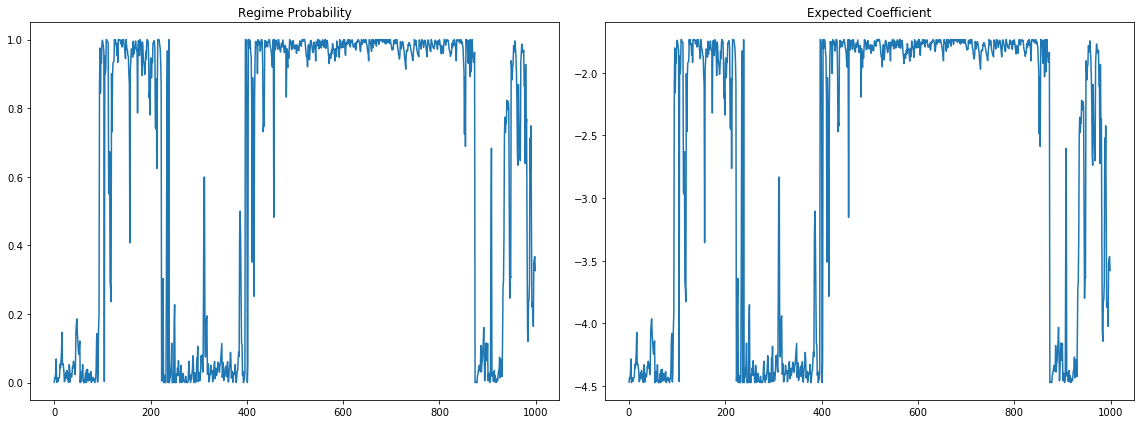

In [17]:
# Regime probability and expected slope coef

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6) )
p0 = res_hamilton.filtered_marginal_probabilities[:,0]
axes[0].plot(p0)
axes[0].set_title('Regime Probability')


beta_hat = p0*res_hamilton.params[-3] + (1-p0)*res_hamilton.params[-2]
axes[1].plot(beta_hat)
axes[1].set_title('Expected Coefficient')
#axes[1].set_ylim([0,1.75])

fig.tight_layout()


## MCMC


In [18]:
# MCMC

# Set up pymc3 model object with likelihood
model = pm.Model()
with model:
    # alpha and beta coefs
    #sigma_a = pm.HalfNormal('sigma_a',sd=.2)
    #a_t = GaussianRandomWalk('a_t', tau=sigma_a**-1, shape=T)
    sigma_b = pm.HalfNormal('sigma_b',sd=.2)
    b_t = GaussianRandomWalk('b_t', tau=sigma_b**-1, shape=Total_T)
    # Define likelihood
    sigma = pm.HalfNormal('sigma',sd=.2)
    #likelihood = pm.Normal('y', mu=a_t + b_t*x, sd=sigma, observed=y)
    likelihood = pm.Normal('y', mu=b_t*x, sd=sigma, observed=y)

# estimate
# Note: can take a while to run
with model:
    trace = pm.sample(Total_T*2, tune=Total_T)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 5,255.6: 100%|██████████| 200000/200000 [00:44<00:00, 4493.87it/s]
Finished [100%]: Average ELBO = 5,256
100%|██████████| 2000/2000 [01:48<00:00, 31.34it/s]


In [19]:
beta_hat = trace.get_values('b_t')

st = pd.DataFrame((pm.stats.df_summary(trace)['mean']))
st = st.ix['b_t__0':'b_t__499']
#st.index = range(Total_T)

/Users/Xinhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


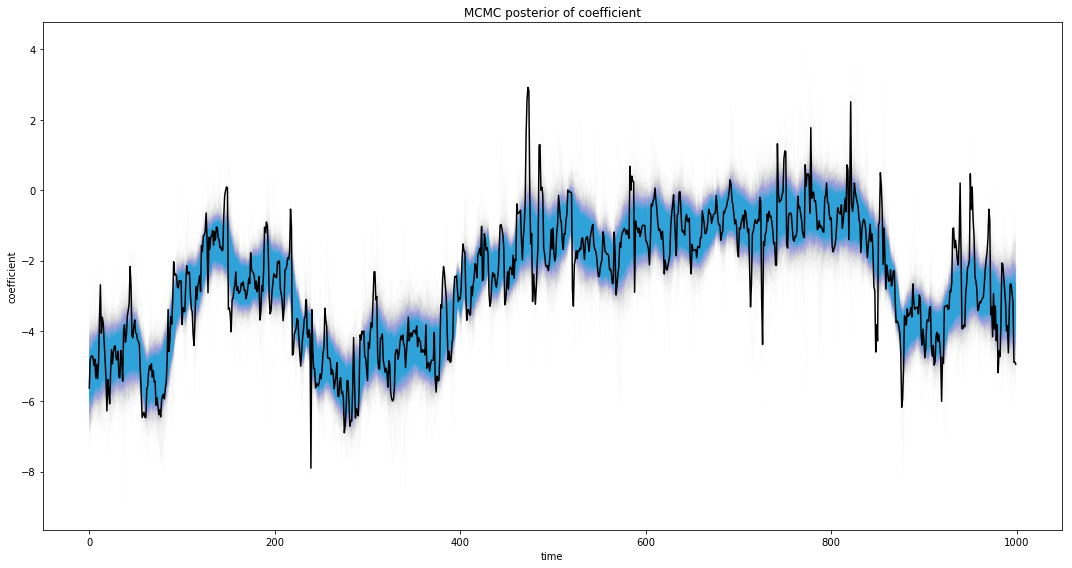

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(beta_hat.T, alpha=.0025, color='#30a2da');
ax.plot(-np.array(D[:Total_T]), color='k')
#ax.plot(st, color='r', lw=5)

#ax.set_ylim([0,1.75])

ax.set(title='MCMC posterior of coefficient', xlabel='time', ylabel='coefficient');
#ax.legend(['True','Mean'])

plt.tight_layout()